# R2X: Plexos & Sienna Comparison

In [67]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from _helpers import add_missing_carriers

In [ ]:
colors_fuel = {
    "Natural gas": "#800080",
    "Hydropower": "#1f77b4",
    "Wind": "#87ceeb", 
    "Biopower": "#228b22",
    "Geothermal": "#8b4513",   
    "PV": "#ffd700",          
    "Storage": "#5dbb26",  
    "Storage_Charge": "#5dbb26",
    "Storage_Discharge": "#5dbb26",
    "Petroleum": "#333333", 
    "Other": "#bcbd22",     
    "Unserved Energy": "#ff0000", 
    "Curtailment": "#ff6347", 
    "Over Generation": "#00ff00",
}

fuel_name_mapper = { # Maps fuel names/ PM names to the fuel names used in Sienna data
    'OIL': 'Petroleum',
    'OTHER': 'Other',
    'HY': 'Hydropower',
    'WT': 'Wind',
    'WOOD_WASTE': 'Biopower',
    'WASTE_HEAT': 'Other',
    'GEOTHERMAL': 'Geothermal',
    'GAS': 'Natural gas',
    'PV': 'PV',
    'BA': 'Storage',
    'HYDROGEN': 'Other',
}


In [29]:
sienna_results_folder = Path('run_output/output_test')
plexos_results_path = Path('PLEXOS ST Results NVE 7_19_24  No AS 2030-2.xlsx')

## Demand Comparison

In [30]:
# Read Sienna Demand
df_sienna_demand = (pd.read_csv(sienna_results_folder / 'load_active_power.csv') *-1)
df_sienna_demand

,DateTime,Nevada Power,Sierra
0,,2505.00,1832.89
1,,2379.29,1773.25
2,,2319.46,1734.14
3,,2288.37,1724.12
4,,2295.62,1731.20
...,...,...,...
67,,2627.49,1966.15
68,,2567.34,1911.81
69,,2460.36,1846.45
70,,2447.27,1829.74


In [31]:
# Read Plexos Results
df_plexos_load = pd.read_excel(plexos_results_path, sheet_name='Native Load')
df_plexos_load.drop(columns=[	"Parent Name", "Collection", "Property", "Band", "Units"], inplace=True)
df_plexos_load.rename(columns={"Datetime": "DateTime"}, inplace=True)
# Remove any zero load columns
df_plexos_load = df_plexos_load.iloc[:len(df_sienna_demand)]
df_plexos_load.set_index('DateTime', inplace=True)
df_plexos_load = df_plexos_load.loc[:, (df_plexos_load.sum(axis=0) != 0)]
df_plexos_load

,Nevada Power,Sierra
DateTime,,
2030-01-01 00:00:00,2505.00,1832.89
2030-01-01 01:00:00,2379.29,1773.25
2030-01-01 02:00:00,2319.46,1734.14
2030-01-01 03:00:00,2288.37,1724.12
2030-01-01 04:00:00,2295.62,1731.20
...,...,...
2030-01-03 19:00:00,2627.49,1966.15
2030-01-03 20:00:00,2567.34,1911.81
2030-01-03 21:00:00,2460.36,1846.45


<Axes: >

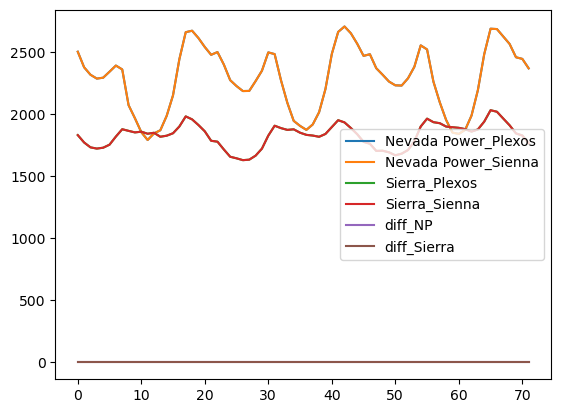

In [32]:
df_plexos_load = df_plexos_load[['Nevada Power', 'Sierra']].add_suffix('_Plexos')
df_sienna_demand = df_sienna_demand[['Nevada Power', 'Sierra']].add_suffix('_Sienna')

df = pd.DataFrame(
    [
        df_plexos_load['Nevada Power_Plexos'].reset_index(drop=True), 
        df_sienna_demand['Nevada Power_Sienna'].reset_index(drop=True),
        df_plexos_load['Sierra_Plexos'].reset_index(drop=True),
        df_sienna_demand['Sierra_Sienna'].reset_index(drop=True),
        ]
).T

df['diff_NP'] = df['Nevada Power_Plexos'] - df['Nevada Power_Sienna']
df['diff_Sierra'] = df['Sierra_Plexos'] - df['Sierra_Sienna']
df
df.plot()

## Generation Comparison

In [33]:
# Load Generator Fuel Mapping File
gen_properties = pd.read_csv(Path('../output_test/gen.csv'), index_col=0)
gen_properties['fuel_type'] = gen_properties.fuel.fillna(gen_properties.unit_type)
gen_properties['fuel_name'] = gen_properties.fuel_type.map(fuel_name_mapper)
print(gen_properties.fuel_name.unique())
print(gen_properties.fuel_type.unique())

['PV' 'Storage' 'Natural gas' 'Other' 'Geothermal' 'Wind' 'Biopower'
 'Petroleum' 'Hydropower']
['PV' 'BA' 'GAS' 'HYDROGEN' 'GEOTHERMAL' 'WT' 'WOOD_WASTE' 'OIL' 'HY'
 'WASTE_HEAT']


In [63]:
# Read Plexos Results
df_plexos_generation = pd.read_excel(plexos_results_path, sheet_name='Generation')
df_plexos_generation.drop(columns=[	"Parent Name", "Collection", "Property", "Band", "Units"], inplace=True)
df_plexos_generation.rename(columns={"Datetime": "DateTime"}, inplace=True)
df_plexos_generation.set_index('DateTime', inplace=True)
# Add storage data
df_plexos_storage = pd.read_excel(plexos_results_path, sheet_name='Net_Gen (stor)')
df_plexos_storage.drop(columns=["Parent Name", "Collection", "Property", "Band", "Units"], inplace=True)
df_plexos_storage.rename(columns={"Datetime": "DateTime"}, inplace=True)
df_plexos_storage.set_index('DateTime', inplace=True)

df_plexos_generation = pd.concat([df_plexos_generation, df_plexos_storage], axis=1)
df_plexos_generation.head(5)

,Chuck Lenzi 1_A,Chuck Lenzi 1_B,Chuck Lenzi 2_A,Chuck Lenzi 2_B,"Clark 5, 6, 10_A","Clark 5, 6, 10_B","Clark 7, 8, 9_A","Clark 7, 8, 9_B",Harry Allen CC_A,Harry Allen CC_B,...,Arrow Canyon Solar BESS,Battle Mountain Solar BESS,Boulder Solar III BESS,Dodge Flat Solar BESS,Dry Lake East Solar BESS,Dry Lake Solar BESS,Fish Springs Ranch Solar BESS,Gemini Solar BESS,Libra Solar BESS,Sierra Solar BESS
DateTime,,,,,,,,,,,,,,,,,,,,,
2030-01-01 00:00:00,268.389,268.389,268.389,268.389,0,0,0,0,290.0,290.0,...,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.00,0.000,0.0
2030-01-01 01:00:00,268.389,268.389,268.389,268.389,0,0,0,0,290.0,290.0,...,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.00,0.000,0.0
2030-01-01 02:00:00,268.389,268.389,268.389,268.389,0,0,0,0,290.0,290.0,...,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.00,0.000,0.0
2030-01-01 03:00:00,268.389,268.389,268.389,289.944,0,0,0,0,290.0,290.0,...,39.097,0.0,0.000,10.852,0.0,21.704,0.000,0.00,321.845,0.0
2030-01-01 04:00:00,268.389,268.389,268.389,289.944,0,0,0,0,290.0,290.0,...,0.000,0.0,27.759,0.000,0.0,0.000,5.406,47.79,530.083,0.0


In [61]:
# Group plexos results by fuel type
df_plexos_gen_by_fuel = df_plexos_generation.groupby(gen_properties.fuel_name, axis =1).sum()
df_plexos_gen_by_fuel['Storage_Charge'] = df_plexos_gen_by_fuel['Storage'].clip(upper=0)
df_plexos_gen_by_fuel['Storage_Discharge'] = df_plexos_gen_by_fuel['Storage'].clip(lower=0)
df_plexos_gen_by_fuel.drop(columns=['Storage'], inplace=True)
df_plexos_gen_by_fuel.head(5)

/var/folders/00/vqry7y9s78q3rvf_m_jmk_bc0000gn/T/ipykernel_23743/542047842.py:2: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_plexos_gen_by_fuel = df_plexos_generation.groupby(gen_properties.fuel_name, axis =1).sum()


fuel_name,Biopower,Geothermal,Hydropower,Natural gas,Other,PV,Petroleum,Wind,Storage_Charge,Storage_Discharge
DateTime,,,,,,,,,,
2030-01-01 00:00:00,15.2,228.346,7.634,3539.783,6.0,0.0,0.0,538.927,0.0,2.000
2030-01-01 01:00:00,15.2,228.346,7.634,3452.146,6.0,0.0,0.0,441.213,0.0,2.000
2030-01-01 02:00:00,15.2,228.346,7.634,3425.065,6.0,0.0,0.0,369.355,0.0,2.000
2030-01-01 03:00:00,15.2,228.346,7.634,2952.897,6.0,0.0,0.0,406.914,0.0,395.498
2030-01-01 04:00:00,15.2,228.346,7.634,2808.858,6.0,0.0,0.0,347.743,0.0,613.038


In [59]:
df_sienna_gen = pd.read_csv(sienna_results_folder / 'generator_active_power.csv')
df_sienna_gen

,DateTime,Clark 17,Clark Mt. 3,Clark 14,LV Gen 3_A,Clark 13,Sun Peak 3,Clark 18,"Clark 5, 6, 10_A",LV Gen 2_B,...,FRV Spectrum Solar,Boulder Solar II,RV Apex Solar,Arrow Canyon Solar,Silver State Solar,Ft. Churchill Solar,Libra Solar,Gemini Solar,Boulder Solar III,Copper Mountain Solar 5
0,2030-01-01T00:00:00.0,45.200000,72.000000,42.917309,0.00,40.1,0.0,40.1,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2030-01-01T01:00:00.0,35.000000,42.885685,35.000000,0.00,35.0,0.0,35.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2030-01-01T02:00:00.0,35.000000,50.200000,35.000000,0.00,35.0,0.0,35.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2030-01-01T03:00:00.0,45.310103,72.000000,50.300000,0.00,50.3,0.0,50.3,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2030-01-01T04:00:00.0,50.300000,72.000000,50.300000,0.00,50.3,0.0,45.2,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,2030-01-03T19:00:00.0,0.000000,0.000000,0.000000,57.50,0.0,0.0,0.0,0.0,57.50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
68,2030-01-03T20:00:00.0,0.000000,0.000000,0.000000,57.50,0.0,0.0,0.0,0.0,57.50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69,2030-01-03T21:00:00.0,0.000000,0.000000,0.000000,57.50,0.0,0.0,0.0,0.0,57.50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
70,2030-01-03T22:00:00.0,0.000000,0.000000,0.000000,57.50,0.0,0.0,0.0,0.0,54.64,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_sienna_fuel = pd.read_csv(sienna_results_folder / 'generation_by_fuel.csv')
df_sienna_fuel

,Petroleum,Other,Wind,Biopower,Storage,Geothermal,PV,Natural gas,Curtailment
0,0.0,6.0,645.788983,15.2,0.000000,219.509755,527.87,2923.521261,4439.118339
1,0.0,6.0,528.690607,15.2,0.000000,219.509755,664.85,2730.289637,4632.349963
2,0.0,6.0,442.601226,15.2,0.000000,219.509755,637.76,2744.529019,4618.110581
3,0.0,6.0,487.591424,15.2,93.534766,219.509755,144.04,3046.614055,4316.025546
4,0.0,6.0,416.523601,15.2,323.082692,219.509755,0.00,3046.503952,4316.135648
...,...,...,...,...,...,...,...,...,...
67,0.0,6.0,202.585664,15.2,78.798368,219.509755,0.00,4071.546213,3291.093387
68,0.0,6.0,130.730438,15.2,22.091080,219.509755,0.00,4085.618726,3277.020874
69,0.0,6.0,200.915230,15.2,0.000000,219.509755,356.76,3520.425015,3842.214586
70,0.0,6.0,214.797080,15.2,0.000000,219.509755,700.00,3133.503165,4229.136435


<Axes: xlabel='DateTime'>

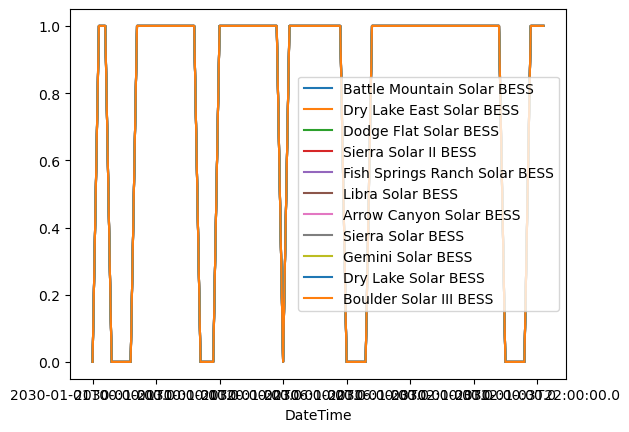

In [65]:
df_storage_charge = pd.read_csv(sienna_results_folder / 'storage_charge.csv', index_col=0)
df_storage_charge.plot()

<Axes: xlabel='DateTime'>

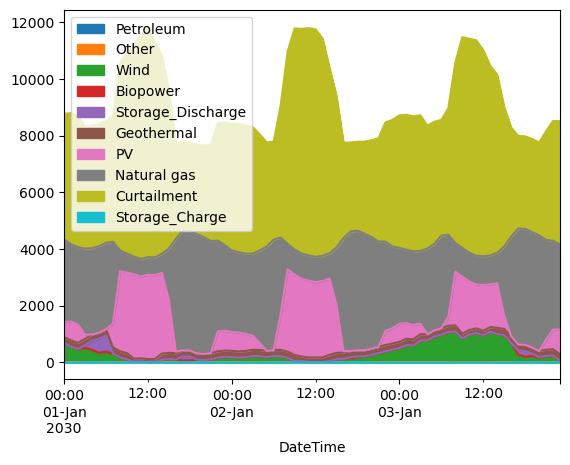

In [ ]:
# Read Sienna Resuts
df_sienna_gen['DateTime'] = pd.to_datetime(df_sienna_gen['DateTime'])
df_sienna_gen.set_index('DateTime', inplace=True)
df_sienna_fuel.Curtailment = df_sienna_fuel.Curtailment.clip(lower=0) # clip small negative curtailment values
df_sienna_fuel.index = df_sienna_gen.index # assign timestamp

df_sienna_fuel['Storage_Charge'] = (df_storage_charge.sum(axis=1) * -1).clip(upper=0).values
df_sienna_fuel.rename(columns={'Storage':'Storage_Discharge'}, inplace=True)
df_sienna_fuel.plot(kind='area', stacked=True)

In [37]:
# modify plot to show imports as thermal
df_sienna_fuel['Natural gas'] = df_sienna_fuel['Natural gas'] + df_sienna_gen[['Southern Purchases (NVP)','Northern Purchases (Sierra)']].sum(axis=1)
df_sienna_fuel['PV'] = df_sienna_fuel['PV'] - df_sienna_gen[['Southern Purchases (NVP)','Northern Purchases (Sierra)']].sum(axis=1)

In [38]:
# Prepare for plotting
plexos = df_plexos_gen_by_fuel.loc[df_sienna_fuel.index].copy()
sienna = df_sienna_fuel
 
COLUMN_ORDER = ['Geothermal', 'Biopower', 'Hydropower', 'Petroleum', 'Other','Natural gas', 'Wind', 'PV', 'Unserved Energy',  'Over Generation', 'Storage_Discharge', 'Storage_Charge']

plexos = plexos.reindex(columns=COLUMN_ORDER)
sienna = sienna.reindex(columns=COLUMN_ORDER)

plexos.head(5)

fuel_name,Geothermal,Biopower,Hydropower,Petroleum,Other,Natural gas,Wind,PV,Unserved Energy,Over Generation,Storage_Discharge,Storage_Charge
DateTime,,,,,,,,,,,,
2030-01-01 00:00:00,228.346,15.2,7.634,0.0,6.0,3539.783,538.927,0.0,NaN,NaN,2.000,0.0
2030-01-01 01:00:00,228.346,15.2,7.634,0.0,6.0,3452.146,441.213,0.0,NaN,NaN,2.000,0.0
2030-01-01 02:00:00,228.346,15.2,7.634,0.0,6.0,3425.065,369.355,0.0,NaN,NaN,2.000,0.0
2030-01-01 03:00:00,228.346,15.2,7.634,0.0,6.0,2952.897,406.914,0.0,NaN,NaN,395.498,0.0
2030-01-01 04:00:00,228.346,15.2,7.634,0.0,6.0,2808.858,347.743,0.0,NaN,NaN,613.038,0.0


In [39]:
# plexos, sienna = add_missing_carriers(plexos, sienna)
start_time = pd.Timestamp(2030, 1, 1)
end_time = pd.Timestamp(2030, 1, 6)

sienna = sienna.loc[start_time:end_time]
plexos = plexos.loc[start_time:end_time]

/Users/kamrantehranchi/miniforge3/envs/pypsa-usa/lib/python3.11/site-packages/pandas/plotting/_matplotlib/core.py:1794: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(None, 0)


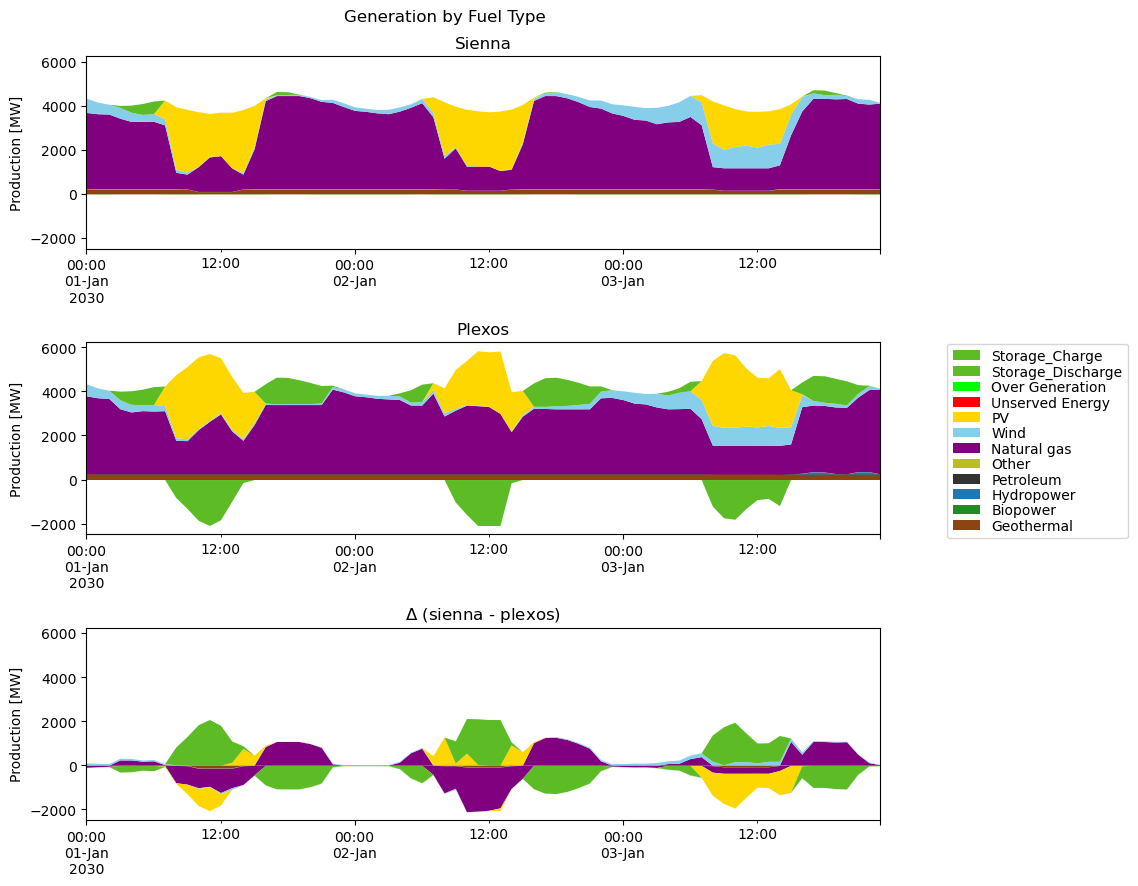

In [40]:
title='Generation by Fuel Type'; save_path='validation/generation_by_fuel.png'; colors=colors_fuel

kwargs = dict(color=colors, ylabel="Production [MW]", xlabel="", linewidth=0)

fig, axes = plt.subplots(3, 1, figsize=(9, 9))

# sienna_resampled = sienna.resample("1D").mean()
sienna.plot.area(
    ax=axes[0],
    **kwargs,
    legend=False,
    title="Sienna",
)
order = sienna.columns

# plexos_resampled = plexos.resample("1D").mean()[order]
plexos.plot.area(
    ax=axes[1],
    **kwargs,
    legend=False,
    title="Plexos",
)

diff = (sienna - plexos).fillna(0)#.resample("1D").mean()
diff.clip(lower=0).plot.area(
    ax=axes[2],
    title=r"$\Delta$ (sienna - plexos)",
    legend=False,
    **kwargs,
)
diff.clip(upper=0).plot.area(ax=axes[2], **kwargs, legend=False)

lower_lim = min(axes[0].get_ylim()[0], axes[1].get_ylim()[0], axes[2].get_ylim()[0])
upper_lim = max(axes[0].get_ylim()[1], axes[1].get_ylim()[1], axes[2].get_ylim()[1])
axes[0].set_ylim(bottom=lower_lim, top=upper_lim)
axes[1].set_ylim(bottom=lower_lim, top=upper_lim)

# Set the limits for the difference subplot
diff_lim_upper = diff.clip(lower=0).sum(axis=1).max()
diff_lim_lower = diff.clip(upper=0).sum(axis=1).min()
axes[2].set_ylim(
    bottom=min(lower_lim, diff_lim_lower),
    top=max(upper_lim, diff_lim_upper),
)

h, l = axes[0].get_legend_handles_labels()
fig.legend(
    h[::-1],
    l[::-1],
    loc="center left",               # Aligns the legend to the left of the bounding box
    bbox_to_anchor=(1.05, 0.5),      # 1.05 moves it slightly outside the plot, 0.5 centers it vertically
    ncol=1,
    frameon=True,
    labelspacing=0.1,
)

plt.suptitle(title)
fig.tight_layout()
fig.savefig(save_path, dpi=300)

In [41]:
df_plexos_match = df_plexos_generation.loc[df_sienna_gen.index, df_sienna_gen.columns]


In [42]:
df_sienna_renewable_parameters = pd.read_csv(sienna_results_folder / 'renewable_parameters.csv')
df_sienna_renewable_parameters.set_index('DateTime', inplace=True)
df_sienna_renewable_parameters.index = pd.to_datetime(df_sienna_renewable_parameters.index)
df_plexos_renew_match = df_plexos_generation.loc[df_sienna_renewable_parameters.index, df_sienna_renewable_parameters.columns]
(df_sienna_renewable_parameters - df_plexos_renew_match).sum().sort_values().head(20)


_NVE IRP Expansion_SPPC_PV (Standalone)   -9047.771997
Northern Purchases (Sierra)                   0.002000
Southern Purchases (NVP)                      0.011000
Fish Springs Ranch Solar                     34.838580
Mountain View Solar                          38.810600
RV Apex Solar                                44.729341
Nellis Solar Array II                        50.100000
Turquoise Nevada                             86.949408
Techren Solar III                            87.335820
Techren Solar IV                             92.386070
Ft. Churchill Solar                          93.349931
Dry Lake Solar                              107.188101
ACE Searchlight Solar                       110.488083
FRV Spectrum Solar                          134.950300
Dry Lake East Solar                         142.919468
Switch Station 2 (Playa Solar 2)            154.710243
Boulder Solar II                            160.124500
Switch Station 1 (Playa Solar 1)            178.643000
Techren So

In [43]:
(df_sienna_gen - df_plexos_match)

,Clark 17,Clark Mt. 3,Clark 14,LV Gen 3_A,Clark 13,Sun Peak 3,Clark 18,"Clark 5, 6, 10_A",LV Gen 2_B,LV Gen 2_A,...,FRV Spectrum Solar,Boulder Solar II,RV Apex Solar,Arrow Canyon Solar,Silver State Solar,Ft. Churchill Solar,Libra Solar,Gemini Solar,Boulder Solar III,Copper Mountain Solar 5
DateTime,,,,,,,,,,,,,,,,,,,,,
2030-01-01 00:00:00,45.200000,72.000000,42.917309,0.00,40.1,0.0,40.1,0.0,0.00,-57.50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2030-01-01 01:00:00,35.000000,42.885685,35.000000,0.00,35.0,0.0,35.0,0.0,0.00,-57.50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2030-01-01 02:00:00,35.000000,50.200000,35.000000,0.00,35.0,0.0,35.0,0.0,0.00,-57.50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2030-01-01 03:00:00,45.310103,72.000000,50.300000,0.00,50.3,0.0,50.3,0.0,0.00,-57.50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2030-01-01 04:00:00,50.300000,72.000000,50.300000,0.00,50.3,0.0,45.2,0.0,0.00,-57.50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2030-01-03 19:00:00,0.000000,0.000000,0.000000,57.50,0.0,0.0,0.0,0.0,57.50,57.50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2030-01-03 20:00:00,0.000000,0.000000,0.000000,57.50,0.0,0.0,0.0,0.0,57.50,57.50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2030-01-03 21:00:00,0.000000,0.000000,0.000000,57.50,0.0,0.0,0.0,0.0,57.50,57.50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<Axes: title={'center': 'Sienna Purchases'}, xlabel='DateTime'>

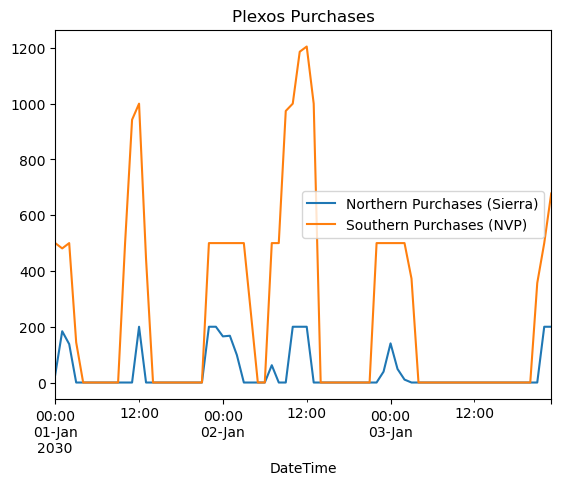

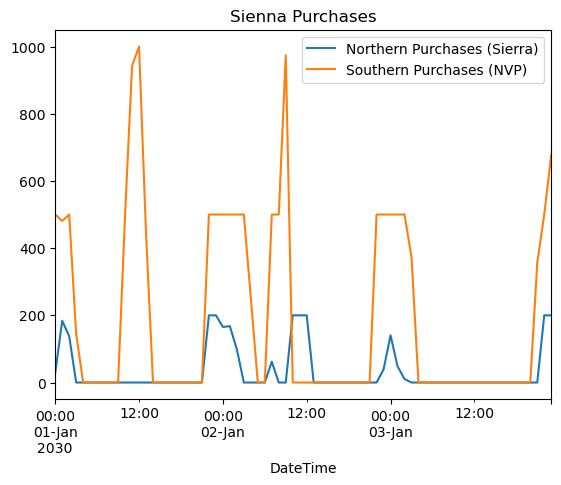

In [44]:
df_plexos_match[['Northern Purchases (Sierra)', 'Southern Purchases (NVP)']].plot(title='Plexos Purchases')
df_sienna_gen[['Northern Purchases (Sierra)', 'Southern Purchases (NVP)']].plot(title='Sienna Purchases')

## Compare Line Flows

In [45]:
# Read Plexos Results
df_plexos_tx = pd.read_excel(plexos_results_path, sheet_name='TX')
df_plexos_tx.drop(columns=[	"Parent Name", "Collection", "Property", "Band", "Units"], inplace=True)
df_plexos_tx.rename(columns={"Datetime": "DateTime"}, inplace=True)
df_plexos_tx.set_index('DateTime', inplace=True)
df_plexos_tx


,Northern Import-Export (Sierra),ON Line (NVP to Sierra),Southern Import-Export (NVP)
DateTime,,,
2030-01-01 00:00:00,27.869,570.611,500.000
2030-01-01 01:00:00,183.896,453.057,480.947
2030-01-01 02:00:00,137.762,530.529,500.000
2030-01-01 03:00:00,0.000,583.761,144.039
2030-01-01 04:00:00,0.000,694.255,0.000
...,...,...,...
2030-01-07 19:00:00,0.000,889.191,0.000
2030-01-07 20:00:00,200.000,777.787,500.000
2030-01-07 21:00:00,200.000,718.808,801.888


In [46]:
# Read Sienna Resuts
df_sienna_tx = pd.read_csv(sienna_results_folder / 'tx_flow.csv')
df_sienna_tx['DateTime'] = pd.to_datetime(df_sienna_tx['DateTime'])
df_sienna_tx.set_index('DateTime', inplace=True)
df_sienna_tx

,Northern Import-Export (Sierra),Southern Import-Export (NVP),ON Line (NVP to Sierra)
DateTime,,,
2030-01-01 00:00:00,27.87,500.00,900.667332
2030-01-01 01:00:00,183.90,480.95,838.682791
2030-01-01 02:00:00,137.76,500.00,922.817889
2030-01-01 03:00:00,0.00,144.04,812.735717
2030-01-01 04:00:00,0.00,0.00,879.272701
...,...,...,...
2030-01-03 19:00:00,0.00,0.00,867.926727
2030-01-03 20:00:00,0.00,0.00,883.478582
2030-01-03 21:00:00,0.00,356.76,960.529639


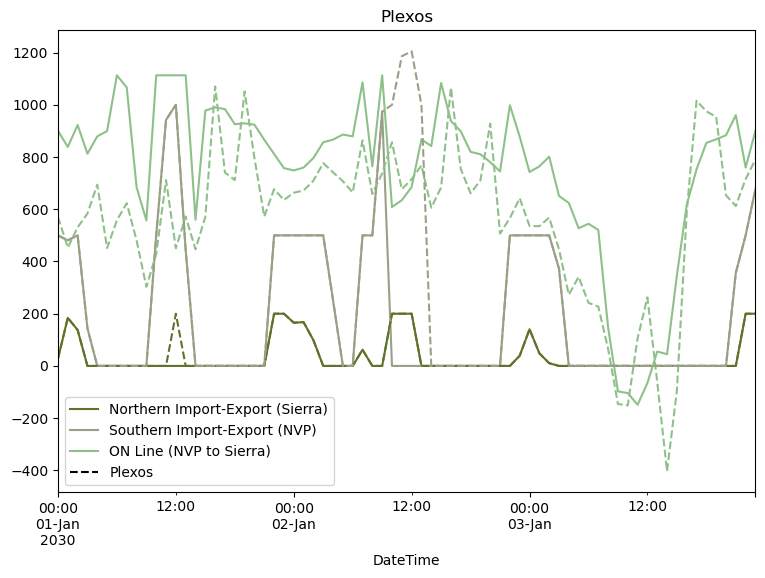

In [47]:
import random
df_plexos_tx = df_plexos_tx.loc[df_sienna_tx.index]

colors_tx = {column: "#" + ''.join(random.choices('0123456789ABCDEF', k=6)) for column in df_sienna_tx.columns}

fig, ax = plt.subplots(1, 1, figsize=(9, 6))
df_sienna_tx.plot(ax=ax, title='Sienna', legend=False, color=colors_tx)
df_plexos_tx.plot(ax=ax, title='Plexos', legend=False, linestyle='--', color=colors_tx)

# Set the same color for lines with the same name
handles, labels = ax.get_legend_handles_labels()
unique_labels = list(set(labels))
unique_handles = [handles[labels.index(label)] for label in unique_labels]

# Add handles for dashed lines
dashed_handles = [plt.Line2D([], [], linestyle='--', color='black', label='Plexos')]
dashed_labels = ['Plexos']

# Combine all handles and labels
all_handles = unique_handles + dashed_handles
all_labels = unique_labels + dashed_labels

ax.legend(all_handles, all_labels)

In [48]:
df_sienna_pc = pd.read_csv(sienna_results_folder / 'production_costs.csv')

df_sienna_pc['DateTime'] = pd.to_datetime(df_sienna_pc['DateTime'])
df_sienna_pc.set_index('DateTime', inplace=True)

df_sienna_pc.sum(axis=1).resample("1D").sum()

DateTime
2030-01-01    1.598819e+06
2030-01-02    1.581380e+06
2030-01-03    1.536866e+06
Freq: D, dtype: float64

In [49]:
def harry_plexos(production):
    constant = 4131.864122174
    set_point_coeff = 4.224868900963997

    tranch_rates = [- 72.18474708879999 , - 62.82746505604, - 54.1187075206, - 46.05847448248, - 38.64676594168,  - 31.8835819350, - 25.7689223889 , - 20.30278734006, - 15.4851767885]

    tranch_coeffs = [0.0693069306930693, 0.0796292395196966, 0.09244314013206, 0.1086206896551725, 0.129452054794,  0.156911581569115,  0.194144838212635, 0.2464146023468058, 0.27]

    tranch_setpoints = [coeff * production for coeff in tranch_coeffs]

    tranch_costs = 0
    for i in range(len(tranch_rates)):
        tranch_costs += tranch_rates[i] * tranch_setpoints[i]

    return (
        constant 
        + set_point_coeff * production
        + tranch_costs
    )


# x = np.linspace(0, 40, 20)
# y = [harry_plexos(i) for i in x]
# plt.plot(x, y)
# # plt.legend()
# y

# Outstanding Issues

## R2X


## Sienna
- MarketBid Cost
- Max Energy Monthly for Market Purchases ThermalStandard Objects, and for The Hydro Resources

Max Energy Month:
- imports as transmission interface with a schedule. ... max energy month gets captured on the interfaces.

Services:
- turn off A/S for storage , and once completely
- export the plexos allocation of reserves to units

Plotting:
- LMP spread